# SARIMAX Forecaster

This notebook provides the benchmark model (SARIMAX) for conditional forecasting of average import prices

Set Directory to main directory

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
os.chdir("/Users/yuanliu/Documents/Erasmus University/MSc Quantitive Marketing and Business Analytics/P3/Seminar Case Study/Data/case_studies_ah/")

## Install Required Packages

In [2]:
pip install pmdarima --quiet


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: /Users/yuanliu/opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from datetime import datetime
import datetime
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
import torch

In [4]:
plt.style.use('ggplot')

colors = plt.cm.Spectral(np.linspace(0,1,30))
plt.rcParams["figure.figsize"] = (20,5)

## Set-Up Model

Select product type from SUNFLOWER OIL, MAIZE or WHEAT

In [5]:
product_type = "SUNFLOWER OIL"

date_filter = datetime.date(year=2018, month=1, day=1)
date_end = datetime.date(year = 2022, month = 10, day = 1)

Organize data in to workable format

In [6]:
if product_type == "WHEAT":
    trade_data = pd.read_csv("Data/wheat.csv")
    
if product_type == "MAIZE":
    trade_data = pd.read_csv("Data/maize_corn.csv")
    
if product_type == "SUNFLOWER OIL":
    trade_data = pd.read_csv("Data/sunflower_oil.csv")
    
trade_data["TIME_PERIOD"] = pd.to_datetime(trade_data["TIME_PERIOD"], format = '%Y-%m').dt.date
trade_data = trade_data.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})

products = trade_data["product"].drop_duplicates().to_list()

if product_type == 'SUNFLOWER OIL' or product_type == 'MAIZE':
    product_filter = products[0]

if product_type == 'WHEAT':
    product_filter = products[1]
    
partner_countries = pd.read_csv("Data/partners.csv", sep = ";")
trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')

trade_data_pivot = trade_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])

trade_data_pivot.columns = trade_data_pivot.columns.map('_'.join)
trade_data_pivot = trade_data_pivot.reset_index()
trade_data_pivot = trade_data_pivot.dropna()


trade_data_total = trade_data_pivot\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

trade_data_total = trade_data_total.reset_index()
trade_data_total['price'] = trade_data_total['OBS_VALUE_VALUE_1000EURO']/trade_data_total['OBS_VALUE_QUANTITY_TON']
trade_data_total = trade_data_total[(trade_data_total["product"] == product_filter)]

# Isolate Ukraine - Netherlands Import data for later use
Ukr_Data = trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Ukraine') & (trade_data_pivot["product"] == product_filter) & (trade_data_pivot["TIME_PERIOD"] >= date_filter)][['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']]
Ukr_Data = Ukr_Data.set_index("TIME_PERIOD")
Ukr_Data = Ukr_Data.rename(columns = {"OBS_VALUE_QUANTITY_TON" : "UKR_QUANTITY"})
trade_data_total['UKR_QUANTITY'] = Ukr_Data['UKR_QUANTITY']
trade_data_total = trade_data_total.fillna(0)

trade_data_total = trade_data_total.set_index("TIME_PERIOD")
trade_data_total = trade_data_total[(trade_data_total.index >= date_filter)]

Add extra CMO data to dataframe

In [7]:
# Import other commodities and use same procedure
oil_data = pd.read_csv("Data/CMO-Historical-Data-Monthly.csv", header = 6)
oil_data = oil_data.rename(columns = {"Unnamed: 0" : "TIME_PERIOD"})
oil_data['TIME_PERIOD'] = oil_data['TIME_PERIOD'].str.replace(r'M', '-')
oil_data["TIME_PERIOD"] = pd.to_datetime(oil_data["TIME_PERIOD"], format = '%Y-%m').dt.date
to_replace = oil_data["SUNFLOWER_OIL"].iloc[0]
oil_data = oil_data.replace(to_replace, 0)
oil_data = oil_data.drop_duplicates()
oil_data = oil_data.set_index("TIME_PERIOD")
oil_data = oil_data[(oil_data.index >= date_filter) & (oil_data.index <= date_end)]

trade_data_total = trade_data_total.reset_index()
oil_data = oil_data.reset_index()

data = trade_data_total.merge(oil_data, on = 'TIME_PERIOD')
data = data[data.columns.drop(list(data.filter(regex='Unnamed')))]
data = data.set_index("TIME_PERIOD")

In [8]:
data.head()

,product,OBS_VALUE_QUANTITY_TON,OBS_VALUE_VALUE_1000EURO,price,UKR_QUANTITY,CRUDE_PETRO,CRUDE_BRENT,CRUDE_DUBAI,CRUDE_WTI,COAL_AUS,...,ALUMINUM,IRON_ORE,COPPER,LEAD,Tin,NICKEL,Zinc,GOLD,PLATINUM,SILVER
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2018-01-01,15121191,4398.3,3521.36,0.800618,0.0,66.23,68.99,66.02,63.67,106.45,...,2209.73,76.34,7065.85,2584.09,20696.91,12864.88,3441.52,1331.30,990.12,17.13
2018-02-01,15121191,3616.5,3120.24,0.862779,0.0,63.46,65.42,62.79,62.17,105.95,...,2181.79,77.46,7006.52,2581.06,21651.55,13595.88,3532.90,1330.73,987.26,16.58
2018-03-01,15121191,37378.6,24630.16,0.658937,0.0,64.17,66.45,63.29,62.76,96.66,...,2069.24,70.35,6799.18,2390.00,21211.94,13392.50,3269.18,1324.66,954.57,16.47
2018-04-01,15121191,8130.4,6134.90,0.754563,0.0,68.79,71.63,68.43,66.32,93.69,...,2254.69,65.75,6851.51,2352.41,21291.10,13938.10,3188.05,1334.76,924.05,16.65
2018-05-01,15121191,38741.8,25706.26,0.663528,0.0,73.43,76.65,73.66,69.98,105.29,...,2299.67,66.10,6825.27,2360.93,20858.83,14366.49,3059.87,1303.45,904.73,16.49


In [9]:
#Determine rolling statistics
data["rolling_avg"] = data["price"].rolling(window=3).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
data["rolling_std"] = data["price"].rolling(window=3).std()

## Forecaster Tool SARIMA

Provide the length of the validation window, consisting of the number of final months of the dataset you want to forecast. The dataset is hereafter divided into training and test set.

In [10]:
months_to_forecast = 2

test_training_split = datetime.date(year = 2022, month = 10 - months_to_forecast, day = 1)

training_data = data[(data.index <= test_training_split)]
test_data = data[(data.index > test_training_split)]

Train the model along with the exogenous main price drivers

In [11]:
# SARIMAX Model
SARIMAX_model = pm.auto_arima(training_data['price'], exogenous=training_data[['NGAS_EUR', 'CRUDE_PETRO', 'UKR_QUANTITY']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True
                             )

In [12]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   56
Model:             SARIMAX(2, 2, 0)x(1, 1, 0, 12)   Log Likelihood                  15.053
Date:                            Wed, 15 Mar 2023   AIC                            -22.106
Time:                                    17:04:00   BIC                            -15.155
Sample:                                01-01-2018   HQIC                           -19.558
                                     - 08-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0983      0.135     -8.161      0.000      -1.362      -0.835
ar.L2         -0.5812      0.131     -4.452      0.000      -0.837      -0.325
ar.S.L12      -0.2710      0.182     -1.493      0.136      -0.627       0.085
sigma2         0.0270      0.007      3.971      0.000       0.014       0.040
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                 0.55
Prob(Q):                              0.46   Prob(JB):                         0.76
Heteroskedasticity (H):               3.67   Skew:                            -0.24
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(training_data['price'], exog=training_data[['NGAS_EUR', 'CRUDE_PETRO', 'UKR_QUANTITY']], order=SARIMAX_model.order, seasonal_orderiterable = SARIMAX_model.seasonal_order, enforce_invertibility=False, enforce_stationarity=False)

results = model.fit(disp=0);

/Users/yuanliu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/yuanliu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Make predictions and extraact confidence intervals to calculate quantile loss function

In [14]:
test_size = len(test_data)
diff = 0
exog_dat = test_data[['NGAS_EUR', 'CRUDE_PETRO', 'UKR_QUANTITY']].head(test_size - diff)

predictions = results.forecast(steps=test_size-diff, exog=exog_dat)

forecast = results.get_prediction(end = len(training_data) + test_size - 1, exog = test_data[['NGAS_EUR', 'CRUDE_PETRO', 'UKR_QUANTITY']])
ci02 = forecast.conf_int(alpha = 0.02)
ci02 = ci02.rename(columns = {"lower price" : "ci02L", "upper price" : "ci02U"})
ci10 = forecast.conf_int(alpha = 0.10)
ci10 = ci10.rename(columns = {"lower price" : "ci10L", "upper price" : "ci10U"})
ci25 = forecast.conf_int(alpha = 0.5)
ci25 = ci25.rename(columns = {"lower price" : "ci25L", "upper price" : "ci25U"})
c50 = forecast.predicted_mean

cis = ((ci02.join(ci10)).join(ci25)).join(c50)

relevant_cis = cis.tail(months_to_forecast)

relevant_cis_unp = relevant_cis.reset_index()

preds_torch = []

for i in range(len(relevant_cis_unp)):
    preds_torch.append(sorted(relevant_cis_unp.loc[i, :].values.flatten().tolist()[1:]))

target_dat = data['price'].tail(months_to_forecast)

target = torch.FloatTensor(target_dat)
y_pred = torch.FloatTensor([preds_torch])
QLoss = torch.mean(QuantileLoss().loss(y_pred, target)).item()
print("Quantile Loss is: ", QLoss)

relevant_cis = relevant_cis.rename(columns={"predicted_mean": "SARIMAX Prediction"}, errors="raise")


Quantile Loss is:  0.48921799659729004


# Plot Results

In [15]:
display(relevant_cis)

,ci02L,ci02U,ci10L,ci10U,ci25L,ci25U,SARIMAX Prediction
2022-09-01,1.570627,2.239098,1.668540,2.141185,1.807956,2.001769,1.904862
2022-10-01,1.836033,2.798044,1.976941,2.657135,2.177578,2.456499,2.317038


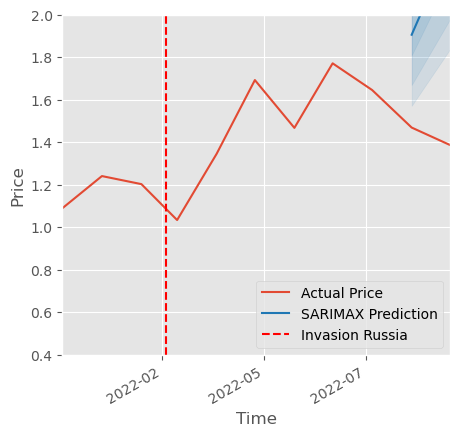

In [16]:
plt.rcParams["figure.figsize"] = (5,5)
import matplotlib.dates as mdates

ax = data['price'].plot(label = 'Actual Price')
relevant_cis[['SARIMAX Prediction']].plot(ax = ax, color = 'tab:blue', label = 'SARIMAX Prediction')
# relevant_cis[['ci02L']].plot(ax = ax, color = 'tab:green', label = 'SARIMAX Prediction', alpha = 0.5, linestyle = '--')
# relevant_cis[['ci02U']].plot(ax = ax, color = 'tab:green', label = 'SARIMAX Prediction')

plt.xlim(
    xmin=datetime.datetime(2021, 12, 1), # the one that doesn't change
    xmax=datetime.datetime(2022, 10, 1) # the latest datetime in your dataset
)

plt.fill_between(relevant_cis.index, relevant_cis['ci02L'], relevant_cis['ci02U'], alpha = 0.1, color = 'tab:blue')
plt.fill_between(relevant_cis.index, relevant_cis['ci10L'], relevant_cis['ci10U'], alpha = 0.1, color = 'tab:blue')
plt.fill_between(relevant_cis.index, relevant_cis['ci25L'], relevant_cis['ci25U'], alpha = 0.1, color = 'tab:blue')

plt.ylim(0.4, 2)
plt.xlim(
    xmin=datetime.datetime(2021, 12, 1),
    xmax=datetime.datetime(2022, 10, 1) 
    )
    
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.axvline(datetime.datetime(2022, 2, 20), color = 'red', linestyle = '--', label = 'Invasion Russia')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc = 'lower right');

Plot quantile loss comparison between TFT and SARIMAX (see result logs)

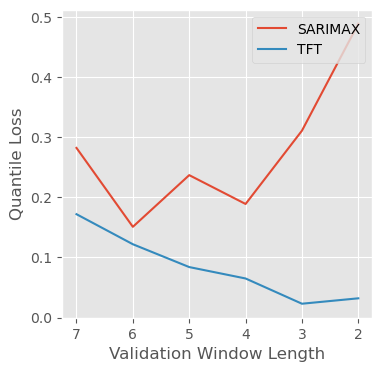

In [18]:
Validation = ['7','6', '5', '4', '3', '2']

SARIMAX_WHEAT = [0.0219, 0.035, 0.011, 0.017, 0.030, 0.052]
SARIMAX_MAIZE = [0.0485 ,0.043, 0.117, 0.025, 0.097, 0.019]
SARIMAX_SUNFLOWER = [0.2823, 0.151, 0.237, 0.189, 0.311, 0.489]

TFT_WHEAT = [0.038, 0.027, 0.015, 0.006, 0.006, 0.004]
TFT_MAIZE = [0.044, 0.024, 0.016, 0.024, 0.018, 0.014]
TFT_SUNFLOWER = [0.172, 0.122, 0.084, 0.065, 0.023, 0.032]

plt.rcParams["figure.figsize"] = (4,4)

plt.ylabel('Quantile Loss')
plt.xlabel('Validation Window Length')
plt.plot(Validation, SARIMAX_SUNFLOWER, label = 'SARIMAX')
plt.plot(Validation, TFT_SUNFLOWER, label = 'TFT')
plt.legend(loc = 'upper right');

